In [6]:
from torch.autograd import Variable
import torch
import torch.autograd
import torch.nn.functional as F
import random
import numpy as np
from params_poly import p
import matplotlib.pyplot as plt
from torch import nn
import torch.optim as optim
from tqdm import tqdm
import pickle as pkl
from os.path import join as oj
import numpy.random as npr
import numpy.linalg as npl
from copy import deepcopy
import pandas as pd
import seaborn as sns
from fit import *
import viz

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# run

In [9]:
class p:
    hidden_size = 64
    repeats = 1
    opt = 'adam'
    lr = 1e-2
    N = 1000
    d = 3 # number of input features
    num_iters = int(1e3)
    num_layers = 1 #, 2, 6]
    use_bias = True
    loss_thresh = 1e-6
    seed = 13
    func = 'y=x_0=2x_1'# 'x0_sqrtx1_sqrtx2'
    
    def _dict(self):
        return {attr: val for (attr, val) in vars(p).items()
                 if not attr.startswith('_')}


    
    


device = 'cuda'
num_layers = [1, 2, 3, 4, 5, 6, 7]
rs = []
for i, num_lays in enumerate(num_layers):
    p.num_layers = num_lays
    r, X, Y = fit(p)
    rs.append(r)

100%|██████████| 1000/1000 [00:07<00:00, 129.54it/s]


# analyze results

/usr/local/linux/anaconda3.7/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


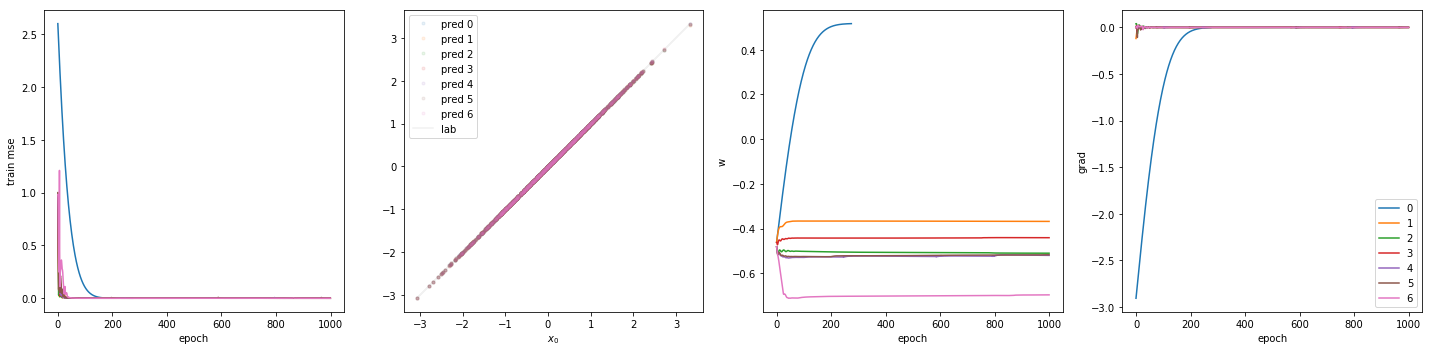

In [12]:
viz.basic_viz(rs, X, Y, device=device)

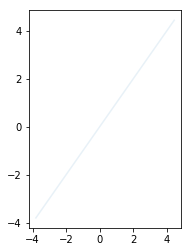

In [16]:
r = pd.DataFrame(rs)
num_vars = 2
n_test = 10000
X_test, Y_test = get_data(p.d, n_test, p.func, grid=True, seed_val=p.seed)

plt.subplot(1, num_vars, 1)
plt.plot(X_test[:, 0], Y_test, label='lab', alpha=0.1)

output = np.zeros((num_vars, results.shape[0]))
for num in range(num_vars):
    X_test, Y_test = get_data(p.d, n_test, p.func, grid=True, seed_val=p.seed)
    X_test_alt, Y_test_alt = get_data(p.d, n_test, p.func, grid=True, shufflevar=num, seed_val=p.seed)
    for i, row in r.iterrows():

        m = row.model    
        pred = m(torch.Tensor(X_test).to(device)).cpu().detach().numpy()
        pred_alt = m(torch.Tensor(X_test_alt).to(device)).cpu().detach().numpy()
        
        
         

        test_mse = np.sum((pred - Y_test)**2) / n_test
        test_mse_alt = np.sum((pred_alt - Y_test_alt)**2) / n_test
#         print(f'using only var $x_{num}$ num_lays {i} mse {test_mse:0.2e}')
        
        output[num, i] = -1 * (test_mse - test_mse_alt)
        
        '''
        plt.subplot(1, num_vars, num + 1)        
        plt.plot(X_test_alt[:, num], pred_alt, '.', label=str(i), alpha=0.1,)
        plt.xlabel(f'$x_{num}$')
        plt.legend()   
        '''

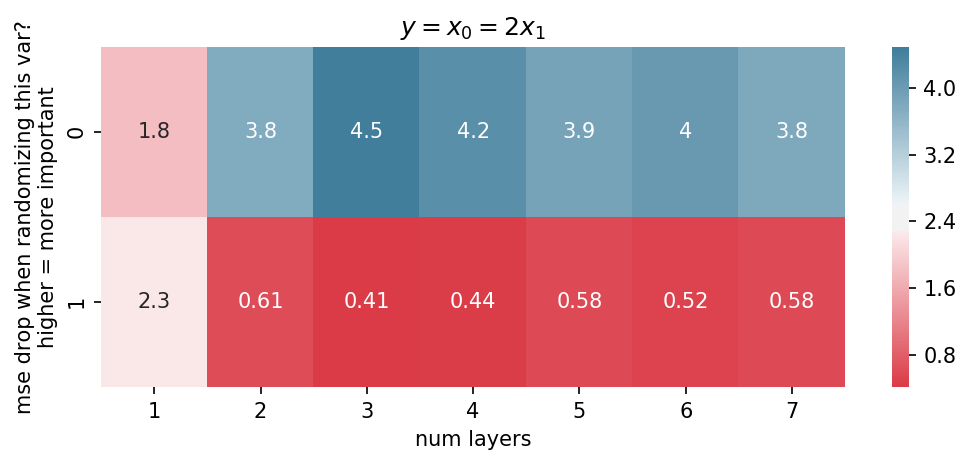

In [18]:
plt.figure(dpi=150, figsize=(8, 3))
# plt.imshow(output)
cmap = sns.diverging_palette(10, 230, sep=20, as_cmap=True)
plt.title(f'${p.func}$')
sns.heatmap(output, cmap=cmap, annot=True)
plt.ylabel('mse drop when randomizing this var?\nhigher = more important')
# plt.yticks(range(num_vars) )
plt.xlabel('num layers')
plt.xticks(np.arange(results.shape[0]) + 0.5, labels=1 + np.arange(results.shape[0]))
# plt.colorbar()
plt.show()

In [33]:
row = results.iloc[0]
print(row.num_layers)

1


In [34]:
row['w'][-1]

array([ 5.1686448e-01,  9.6438408e-01, -2.6361111e-05], dtype=float32)

In [30]:
np.linalg.pinv(X.T @ X) @ X.T @ Y

array([[ 8.00000000e-01],
       [ 4.00000000e-01],
       [-2.77555756e-17]])